In [74]:

import datetime
import pandas as pd
from matplotlib import pyplot as plt
# import pandas_datareader.data as web
import logging
import  numpy as np 
import yfinance as yf 
from ta.volatility import BollingerBands
from ta.momentum import  RSIIndicator
from ta.trend import  MACD
from scipy import stats
import warnings 
warnings.filterwarnings('ignore')


%matplotlib inline



In [18]:

# df = yf.download('MSFT', 
#                      start='2019-01-01', 
#                      end='2021-06-12', 
#                      progress=False,
#)
#highesgdf    =    highesgdf['Adj Close'] 


#df.head()



In [19]:

# Amzndf = yf.download('META', 
#                     start='2020-01-02', 
#                       end='2021-06-12', 
#                       progress=False,
# )
# #highesgdf    =    highesgdf['Adj Close'] 


# Amzndf.head()




In [20]:


# Amzndf.to_csv('Amzndf20200102_20210612.csv')   



In [21]:

# df.to_csv('MSFT_20190101_20200612.csv')



In [22]:

msft_df = pd.read_csv('MSFT_20190101_20200612.csv')

msft_df['Date'] = pd.to_datetime(msft_df['Date'])     
  
msft_df.set_index(msft_df['Date'], inplace =True) 

msft_df.drop(columns =['Date'], inplace =True) 
msft_df.rename(columns  = {'Adj Close':'Adj_Close'}, inplace = True )  

msft_df






,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2018-12-31,101.290001,102.400002,100.440002,101.570000,97.787163,33173800
2019-01-02,99.550003,101.750000,98.940002,101.120003,97.353905,35329300
2019-01-03,100.099998,100.190002,97.199997,97.400002,93.772469,42579100
2019-01-04,99.720001,102.510002,98.930000,101.930000,98.133751,44060600
2019-01-07,101.639999,103.269997,100.980003,102.059998,98.258904,35656100
...,...,...,...,...,...,...
2021-06-07,249.979996,254.089996,249.809998,253.809998,251.754272,23079200
2021-06-08,255.160004,256.010010,252.509995,252.570007,250.524338,22455000
2021-06-09,253.809998,255.529999,253.210007,253.589996,251.536072,17937600


In [23]:

msft_df.dtypes 



Open         float64
High         float64
Low          float64
Close        float64
Adj_Close    float64
Volume         int64
dtype: object

In [24]:

## Checking for null values
msft_df.isna().values.any()

False

In [25]:
#  Checking if trading occured all days in the dataframe

msft_df[msft_df.Volume==0]

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,


In [26]:

train_msft_df = msft_df.loc[pd.datetime(2019,1,1):pd.datetime(2020,1,1),:]








### Development of strategy with past data (Training)




In [27]:


def crossed(series1, series2, direction=None):
    if isinstance(series1, np.ndarray):
        series1 = pd.Series(series1)

    if isinstance(series2, (float, int, np.ndarray)):
        series2 = pd.Series(index=series1.index, data=series2)

    if direction is None or direction == "above":
        above = pd.Series((series1 > series2) & (
            series1.shift(1) <= series2.shift(1)))

    if direction is None or direction == "below":
        below = pd.Series((series1 < series2) & (
            series1.shift(1) >= series2.shift(1)))

    if direction is None:
        return above or below

    return above if direction == "above" else below


def crossed_above(series1, series2):
    return crossed(series1, series2, "above")


def crossed_below(series1, series2):
    return crossed(series1, series2, "below")




### Bollinger bands 

In [28]:

def bb_bands(df):
    # Initialize Bollinger Bands Indicator
    indicator_bb = BollingerBands(close=df.Adj_Close, window=20, window_dev=2)

    # Add Bollinger Bands features
    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    df['bb_bbh'] = indicator_bb.bollinger_hband()
    df['bb_bbl'] = indicator_bb.bollinger_lband()

    # # Add Bollinger Band high indicator
    # df['bb_sell'] = indicator_bb.bollinger_hband_indicator()

    # # Add Bollinger Band low indicator
    # df['bb_buy'] = indicator_bb.bollinger_lband_indicator()


    df['bb_buy_manl'] =  np.where(crossed_below( df.Adj_Close , df.bb_bbl)  ,1,0)               
    

    df['bb_sell_manl'] =  np.where(crossed_above( df.Adj_Close , df.bb_bbh)  ,1,0) 






In [29]:

bb_bands(train_msft_df)


### Ploting of the bollinger bands with the signals and closing prices(Training)

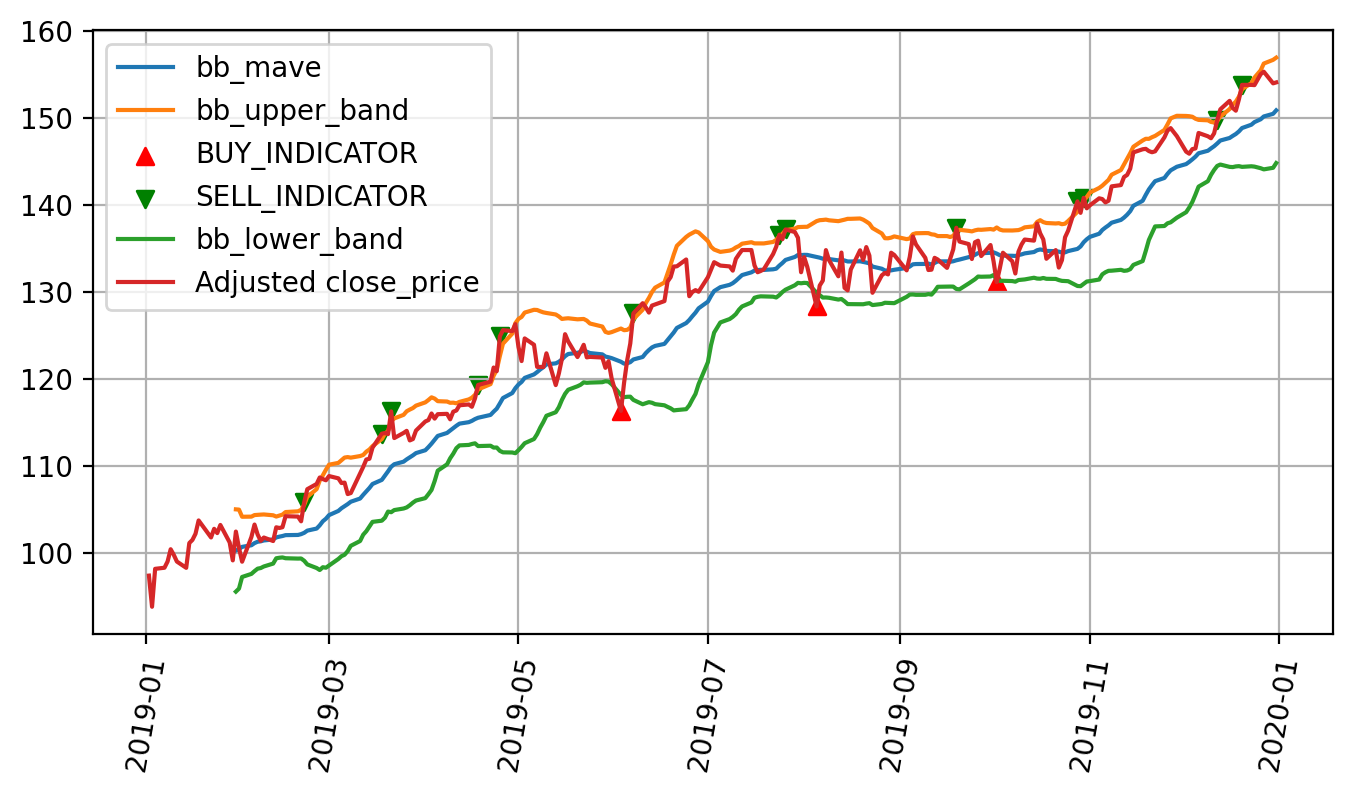

In [30]:

plt.figure(figsize = (8,4), dpi = 200)

plt.plot(train_msft_df.index, train_msft_df.bb_bbm , label = 'bb_mave')
plt.plot(train_msft_df.index, train_msft_df.bb_bbh , label = 'bb_upper_band')
plt.scatter(train_msft_df[train_msft_df.bb_buy_manl ==1].index, train_msft_df[train_msft_df.bb_buy_manl ==1].Adj_Close  ,marker="^",color = 'red', label = 'BUY_INDICATOR')
plt.scatter(train_msft_df[train_msft_df.bb_sell_manl ==1].index, train_msft_df[train_msft_df.bb_sell_manl ==1].Adj_Close , marker="v",color = 'green',label = 'SELL_INDICATOR')
plt.plot(train_msft_df.index, train_msft_df.bb_bbl , label = 'bb_lower_band')
plt.plot(train_msft_df.index, train_msft_df.Adj_Close , label = 'Adjusted close_price')
plt.xticks(rotation=80)
plt.grid()
plt.legend()
plt.show()




### Plotting of the   Adjusted closing prices together with the signals

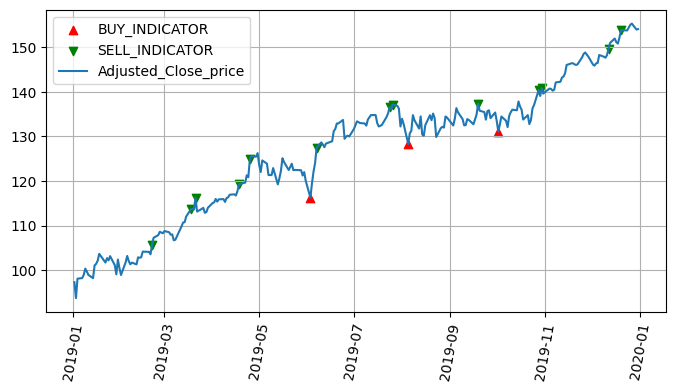

In [31]:



plt.figure(figsize = (8,4), dpi = 100)

plt.scatter(train_msft_df[train_msft_df.bb_buy_manl ==1].index, train_msft_df[train_msft_df.bb_buy_manl ==1].Adj_Close  ,marker="^",color = 'red', label = 'BUY_INDICATOR')
plt.scatter(train_msft_df[train_msft_df.bb_sell_manl ==1].index, train_msft_df[train_msft_df.bb_sell_manl ==1].Adj_Close , marker="v",color = 'green',label = 'SELL_INDICATOR')
plt.plot(train_msft_df.index, train_msft_df.Adj_Close , label = 'Adjusted_Close_price')
plt.xticks(rotation=80)
plt.grid()
plt.legend()
plt.show()





### Filtering out only the buy and sell signal candles(training)

In [32]:


def filter_bb_sigs(df):
    buy_df = df[df.bb_buy_manl ==1]


    sell_df =  df[df.bb_sell_manl ==1]

    sig_df  = pd.concat([sell_df, buy_df] , axis =0)
    
    sig_df.sort_index(inplace =True )
    #### making a dataframe of only columns we will be using
    bb_df  = sig_df[['Adj_Close', 'bb_sell_manl', 'bb_buy_manl']]                            

    return bb_df



In [33]:
tr_msft_bb_df = filter_bb_sigs(train_msft_df)


### Defining the function criticize

In [34]:

def criticize(df, buy_col_nm):
    """
    This function removes all SELL signals before the first BUY signal,
    removes all BUY signals after the last SELL signal and
    also removes multiple signal after the first opposite signal
    
    """
    df['critic'] =0
    k =1.0
    for i in range(len(df)):
        if df[buy_col_nm][i] ==k:
            df['critic'][i] =1.0
            k = not k
        
        else:
            df['critic'][i] =0.0
        
        


In [35]:
criticize(tr_msft_bb_df, 'bb_buy_manl' )

tr_main_trade_df = tr_msft_bb_df[tr_msft_bb_df.critic ==1]


### Plotting the main signals we will be using(Training)

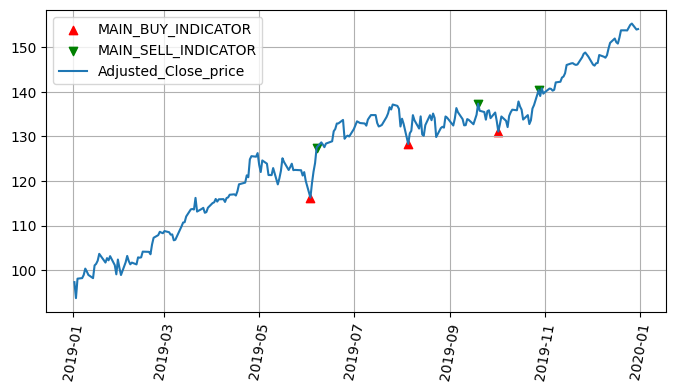

In [36]:



plt.figure(figsize = (8,4), dpi = 100)

plt.scatter(tr_main_trade_df[tr_main_trade_df.bb_buy_manl ==1].index, tr_main_trade_df[tr_main_trade_df.bb_buy_manl ==1].Adj_Close  ,marker="^",color = 'red', label = 'MAIN_BUY_INDICATOR')
plt.scatter(tr_main_trade_df[tr_main_trade_df.bb_sell_manl ==1].index, tr_main_trade_df[tr_main_trade_df.bb_sell_manl ==1].Adj_Close , marker="v",color = 'green',label = 'MAIN_SELL_INDICATOR')
plt.plot(train_msft_df.index, train_msft_df.Adj_Close , label = 'Adjusted_Close_price')
plt.xticks(rotation=80)
plt.grid()
plt.legend()
plt.show()


### Defining the backtesting function

In [37]:
def backtest(df,buy_col_nm,sell_col_nm,  init_amt,commision):
    buy_prices= []
    sell_prices = []
    no_of_stocks_buy = []
    no_of_stocks_sell = []
    buy_date =[]
    buy_comms =[] 
    amt_lefts_buy = []
    sell_date = []
    sell_comms =[] 
    amt_lefts_sell = []

    amt_left = init_amt
    comm = commision
    for ii in range(len(df)):
        
        if df[buy_col_nm][ii] == 1.0:
            amt_lefts_buy.append(amt_left)
            amt_commb = comm * amt_left
            amt_left -= amt_commb 
            no_of_stocks= amt_left/df.Adj_Close[ii]
            no_of_stocks_buy.append(no_of_stocks)
            buy_prices.append(df.Adj_Close[ii])
            buy_date.append(list(df.index)[ii])
            buy_comms.append(amt_commb)  
        elif df[sell_col_nm][ii] == 1.0:
            no_of_stocks_sell.append(no_of_stocks)
            amt_left = no_of_stocks * df.Adj_Close[ii]
            amt_comms = comm * amt_left
            amt_left -= amt_comms
            amt_lefts_sell.append(amt_left)
            sell_prices.append(df.Adj_Close[ii])
            sell_date.append(list(df.index)[ii])
            sell_comms.append(amt_comms)  


    trade_rec_arr = np.array([buy_prices,
    sell_prices,
    # no_of_stocks_buy ,
    no_of_stocks_sell,
    buy_date,b
    buy_comms,                           
    amt_lefts_buy,
    sell_date,
    sell_comms,                           
    amt_lefts_sell])

    trade_rec_df = pd.DataFrame(trade_rec_arr.T , columns= ['Buy_Price', 'Sell_Price','No_of_Stocks','Buy_Date','Buy_commision', "Tot_buy_price", 'Sell_Date','Sell_commision', 'Tot_sell_price'])
    trade_rec_df["Returns"] = (trade_rec_df.Tot_sell_price - trade_rec_df.Tot_buy_price)/ trade_rec_df.Tot_buy_price
    trade_rec_df["CummReturns"]  = trade_rec_df["Returns"].cumsum()
    rfr = 0.02
    std_ = trade_rec_df["Returns"].std()
    sr = (trade_rec_df["Returns"].sum() - rfr)/std_
    skewness =stats.skew(trade_rec_df["Returns"], axis=0, bias=True)
    kurtosis = skewhighesg =stats.kurtosis(trade_rec_df["Returns"], axis=0, bias=True)
    return trade_rec_df





In [38]:


tr_backtest_df = backtest(tr_main_trade_df,'bb_buy_manl', 'bb_sell_manl' ,10000000,0.01)


tr_backtest_df




,Buy_Price,Sell_Price,No_of_Stocks,Buy_Date,Buy_commision,Tot_buy_price,Sell_Date,Sell_commision,Tot_sell_price
0,116.298355,127.516716,85125.881542,2019-06-03,100000.0,10000000,2019-06-07,108549.728611,10746423.132533
1,128.302795,137.356827,82920.710084,2019-08-05,107464.231325,10746423.132533,2019-09-19,113897.256117,11275828.355588
2,131.105804,140.394684,85145.5061,2019-10-02,112758.283556,11275828.355588,2019-10-28,119539.764092,11834436.645094


In [39]:


tr_backtest_df['Trade_Returns']  =  tr_backtest_df.Tot_sell_price - tr_backtest_df.Tot_buy_price                    

tr_backtest_df


,Buy_Price,Sell_Price,No_of_Stocks,Buy_Date,Buy_commision,Tot_buy_price,Sell_Date,Sell_commision,Tot_sell_price,Trade_Returns
0,116.298355,127.516716,85125.881542,2019-06-03,100000.0,10000000,2019-06-07,108549.728611,10746423.132533,746423.132533
1,128.302795,137.356827,82920.710084,2019-08-05,107464.231325,10746423.132533,2019-09-19,113897.256117,11275828.355588,529405.223055
2,131.105804,140.394684,85145.5061,2019-10-02,112758.283556,11275828.355588,2019-10-28,119539.764092,11834436.645094,558608.289505


### Testing strategy with forthcoming data

In [40]:

test_msft_df = msft_df.loc[pd.datetime(2020,1,1):,:]
bb_bands(test_msft_df)
test_msft_df


,Open,High,Low,Close,Adj_Close,Volume,bb_bbm,bb_bbh,bb_bbl,bb_buy_manl,bb_sell_manl
Date,,,,,,,,,,,
2020-01-02,158.779999,160.729996,158.330002,160.619995,156.924393,22622100,NaN,NaN,NaN,0,0
2020-01-03,158.320007,159.949997,158.059998,158.619995,154.970398,21116200,NaN,NaN,NaN,0,0
2020-01-06,157.080002,159.100006,156.509995,159.029999,155.371002,20813700,NaN,NaN,NaN,0,0
2020-01-07,159.320007,159.669998,157.320007,157.580002,153.954346,21634100,NaN,NaN,NaN,0,0
2020-01-08,158.929993,160.800003,157.949997,160.089996,156.406586,27746500,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-07,249.979996,254.089996,249.809998,253.809998,251.754272,23079200,245.032492,252.351293,237.713691,0,0
2021-06-08,255.160004,256.010010,252.509995,252.570007,250.524338,22455000,245.328052,253.023006,237.633097,0,0
2021-06-09,253.809998,255.529999,253.210007,253.589996,251.536072,17937600,245.721204,253.830096,237.612313,0,0


### Ploting of the bollinger bands with the signals and closing prices(Testing)


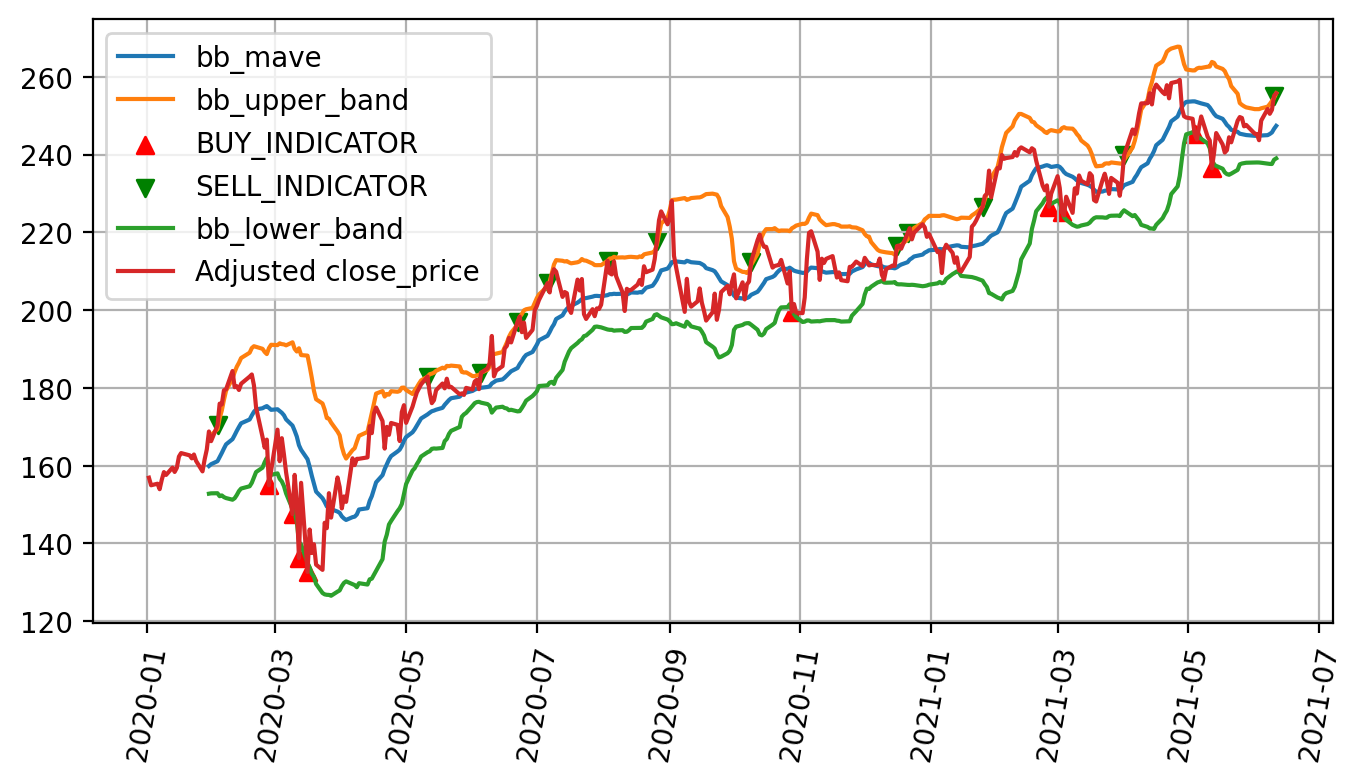

In [41]:


plt.figure(figsize = (8,4), dpi = 200)

plt.plot(test_msft_df.index, test_msft_df.bb_bbm , label = 'bb_mave')
plt.plot(test_msft_df.index, test_msft_df.bb_bbh , label = 'bb_upper_band')
plt.scatter(test_msft_df[test_msft_df.bb_buy_manl ==1].index, test_msft_df[test_msft_df.bb_buy_manl ==1].Adj_Close  ,marker="^",color = 'red', label = 'BUY_INDICATOR')
plt.scatter(test_msft_df[test_msft_df.bb_sell_manl ==1].index, test_msft_df[test_msft_df.bb_sell_manl ==1].Adj_Close , marker="v",color = 'green',label = 'SELL_INDICATOR')
plt.plot(test_msft_df.index, test_msft_df.bb_bbl , label = 'bb_lower_band')
plt.plot(test_msft_df.index, test_msft_df.Adj_Close , label = 'Adjusted close_price')
plt.xticks(rotation=80)
plt.grid()
plt.legend()
plt.show()





### Plotting of the   Adjusted closing prices together with the signals(Testing)

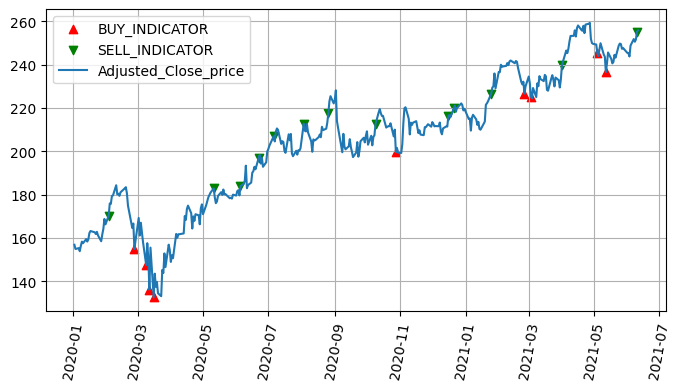

In [42]:
plt.figure(figsize = (8,4), dpi = 100)

plt.scatter(test_msft_df[test_msft_df.bb_buy_manl ==1].index, test_msft_df[test_msft_df.bb_buy_manl ==1].Adj_Close  ,marker="^",color = 'red', label = 'BUY_INDICATOR')
plt.scatter(test_msft_df[test_msft_df.bb_sell_manl ==1].index, test_msft_df[test_msft_df.bb_sell_manl ==1].Adj_Close , marker="v",color = 'green',label = 'SELL_INDICATOR')
plt.plot(test_msft_df.index, test_msft_df.Adj_Close , label = 'Adjusted_Close_price')
plt.xticks(rotation=80)
plt.grid()
plt.legend()
plt.show()

In [62]:


tst_msft_bb_df  = filter_bb_sigs(test_msft_df)

criticize(tst_msft_bb_df,'bb_buy_manl')

tst_main_trade_df = tst_msft_bb_df[tst_msft_bb_df.critic ==1]


# tst_main_trade_df 





### Plotting the main signals we will be using(Testing)

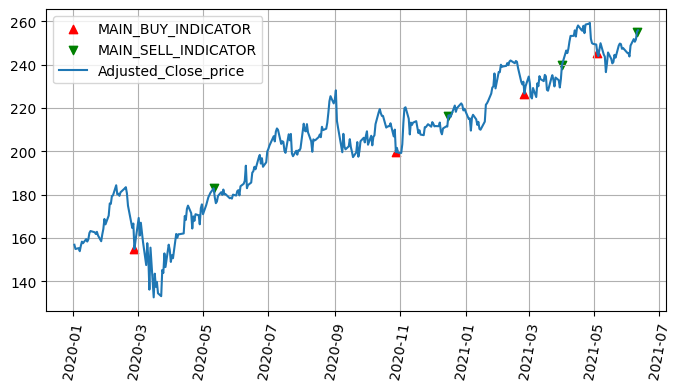

In [45]:




plt.figure(figsize = (8,4), dpi = 100)

plt.scatter(tst_main_trade_df[tst_main_trade_df.bb_buy_manl ==1].index, tst_main_trade_df[tst_main_trade_df.bb_buy_manl ==1].Adj_Close  ,marker="^",color = 'red', label = 'MAIN_BUY_INDICATOR')
plt.scatter(tst_main_trade_df[tst_main_trade_df.bb_sell_manl ==1].index, tst_main_trade_df[tst_main_trade_df.bb_sell_manl ==1].Adj_Close , marker="v",color = 'green',label = 'MAIN_SELL_INDICATOR')
plt.plot(test_msft_df.index, test_msft_df.Adj_Close , label = 'Adjusted_Close_price')
plt.xticks(rotation=80)
plt.grid()
plt.legend()
plt.show()

In [63]:


tst_backtest_df = backtest(tst_main_trade_df,'bb_buy_manl', 'bb_sell_manl' ,10000000,0.01)


tst_backtest_df




,Buy_Price,Sell_Price,No_of_Stocks,Buy_Date,Buy_commision,Tot_buy_price,Sell_Date,Sell_commision,Tot_sell_price
0,154.962662,182.941742,63886.357453,2020-02-27,100000.0,10000000,2020-05-11,116874.815189,11570606.703688
1,199.591827,216.504227,57391.631643,2020-10-28,115706.067037,11570606.703688,2020-12-16,124255.30827,12301275.518745
2,226.612045,239.833298,53740.580065,2021-02-25,123012.755187,12301275.518745,2021-04-01,128887.805389,12759892.733559
3,245.216812,255.156494,51514.794994,2021-05-04,127598.927336,12759892.733559,2021-06-10,131443.344871,13012891.142243



### Check  for overfitting with AMAZON stocks data


In [68]:

amzn_df = pd.read_csv('Amzndf20200102_20210612.csv')

amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])     
  
amzn_df.set_index(amzn_df['Date'], inplace =True) 

amzn_df.drop(columns =['Date'], inplace =True) 
amzn_df.rename(columns  = {'Adj Close':'Adj_Close'}, inplace = True )  

amzn_df






,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000
...,...,...,...,...,...,...
2021-06-07,159.866501,160.399994,158.610001,159.900497,159.900497,44316000
2021-06-08,161.130493,163.976501,160.900497,163.205505,163.205505,68334000
2021-06-09,163.643494,164.878998,163.535004,164.057495,164.057495,49110000


In [69]:

bb_bands(amzn_df)
tst_amzn_bb_df  = filter_bb_sigs(amzn_df)

criticize(tst_amzn_bb_df,'bb_buy_manl')

tst_main_AMZN_trade_df = tst_amzn_bb_df[tst_amzn_bb_df.critic ==1]


tst_backtest_AMZN_df = backtest(tst_main_AMZN_trade_df,'bb_buy_manl', 'bb_sell_manl' ,10000000,0.01)


tst_backtest_AMZN_df


# tst_main_trade_df 





,Buy_Price,Sell_Price,No_of_Stocks,Buy_Date,Buy_commision,Tot_buy_price,Sell_Date,Sell_commision,Tot_sell_price
0,94.214996,108.443497,105078.813191,2020-02-27,100000.0,10000000,2020-04-13,113951.13932,11281162.792652
1,151.807495,162.048004,73569.168348,2020-10-30,112811.627927,11281162.792652,2020-12-16,119217.368978,11802519.528779
2,159.037003,161.336502,73470.287701,2021-02-22,118025.195288,11802519.528779,2021-04-05,118534.392242,11734904.831944
3,159.524506,167.482498,72826.15131,2021-05-10,117349.048319,11734904.831944,2021-06-10,121971.057535,12075134.695932


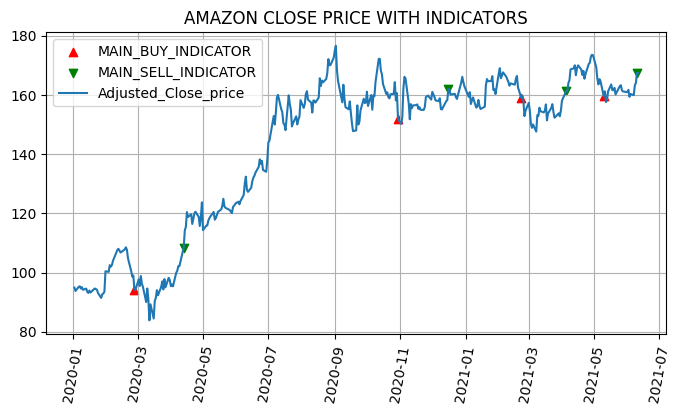

In [72]:




plt.figure(figsize = (8,4), dpi = 100)

plt.scatter(tst_main_AMZN_trade_df[tst_main_AMZN_trade_df.bb_buy_manl ==1].index, tst_main_AMZN_trade_df[tst_main_AMZN_trade_df.bb_buy_manl ==1].Adj_Close  ,marker="^",color = 'red', label = 'MAIN_BUY_INDICATOR')
plt.scatter(tst_main_AMZN_trade_df[tst_main_AMZN_trade_df.bb_sell_manl ==1].index, tst_main_AMZN_trade_df[tst_main_AMZN_trade_df.bb_sell_manl ==1].Adj_Close , marker="v",color = 'green',label = 'MAIN_SELL_INDICATOR')
plt.plot(amzn_df.index, amzn_df.Adj_Close , label = 'Adjusted_Close_price')
plt.xticks(rotation=80)
plt.grid()
plt.title("AMAZON CLOSE PRICE WITH INDICATORS")
plt.legend()
plt.show()

### Check for overfitting FACEBOOK stocks

In [66]:

fb_df = pd.read_csv('Fbdf20200102_20210612.csv')

fb_df['Date'] = pd.to_datetime(fb_df['Date'])     
  
fb_df.set_index(fb_df['Date'], inplace =True) 

fb_df.drop(columns =['Date'], inplace =True) 
fb_df.rename(columns  = {'Adj Close':'Adj_Close'}, inplace = True )  

fb_df






,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2020-01-02,206.750000,209.789993,206.270004,209.779999,209.779999,12090707
2020-01-03,207.213501,210.399994,206.949997,208.669998,208.669998,11197416
2020-01-06,206.699997,212.779999,206.520004,212.600006,212.600006,17073861
2020-01-07,212.820007,214.580002,211.750000,213.059998,213.059998,14604985
2020-01-08,213.000000,216.240005,212.612106,215.220001,215.220001,13492703
...,...,...,...,...,...,...
2021-06-07,329.480011,337.690002,328.929993,336.579987,336.579987,20136707
2021-06-08,336.700012,338.299896,332.239990,333.679993,333.679993,14580464
2021-06-09,335.739990,336.799988,330.000000,330.250000,330.250000,13727946


In [67]:

bb_bands(fb_df)

tst_fb_bb_df  = filter_bb_sigs(fb_df)

criticize(tst_fb_bb_df,'bb_buy_manl')

tst_main_FB_trade_df = tst_fb_bb_df[tst_fb_bb_df.critic ==1]


tst_FB_backtest_df = backtest(tst_main_FB_trade_df,'bb_buy_manl', 'bb_sell_manl' ,10000000,0.01)


tst__FB_backtest_df





,Buy_Price,Sell_Price,No_of_Stocks,Buy_Date,Buy_commision,Tot_buy_price,Sell_Date,Sell_commision,Tot_sell_price
0,201.910004,204.710007,49031.745929,2020-01-31,100000.0,10000000,2020-04-30,100372.890382,9936916.147851
1,216.080002,253.669998,45527.336649,2020-06-26,99369.161479,9936916.147851,2020-07-31,115489.194043,11433430.210221
2,267.089996,279.279999,42379.333046,2020-12-22,114334.302102,11433430.210221,2021-03-16,118357.000814,11717343.080603


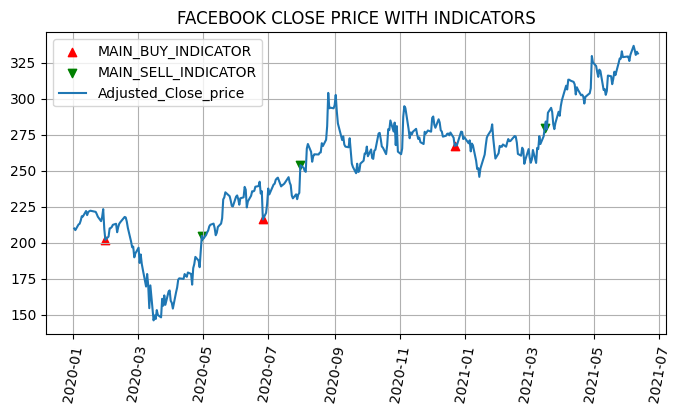

In [73]:


plt.figure(figsize = (8,4), dpi = 100)

plt.scatter(tst_main_FB_trade_df[tst_main_FB_trade_df.bb_buy_manl ==1].index, tst_main_FB_trade_df[tst_main_FB_trade_df.bb_buy_manl ==1].Adj_Close  ,marker="^",color = 'red', label = 'MAIN_BUY_INDICATOR')
plt.scatter(tst_main_FB_trade_df[tst_main_FB_trade_df.bb_sell_manl ==1].index, tst_main_FB_trade_df[tst_main_FB_trade_df.bb_sell_manl ==1].Adj_Close , marker="v",color = 'green',label = 'MAIN_SELL_INDICATOR')
plt.plot(fb_df.index, fb_df.Adj_Close , label = 'Adjusted_Close_price')
plt.xticks(rotation=80)
plt.grid()
plt.title("FACEBOOK CLOSE PRICE WITH INDICATORS")
plt.legend()
plt.show()



### Implementation of strategy RSI indicator



In [49]:
def rsi_strat(df):
    df['RSI'] = RSIIndicator(close = df.Adj_Close, window = 14, fillna= False).rsi()

    df['RSI_sell'] = np.where(df['RSI'] >70,1,0)


    df['RSI_buy'] = np.where(df['RSI'] < 40,1,0)

In [50]:

train_RSI_msft_df = msft_df.loc[pd.datetime(2019,1,1):pd.datetime(2020,1,1),:]

### Formation of signal
rsi_strat(train_RSI_msft_df)


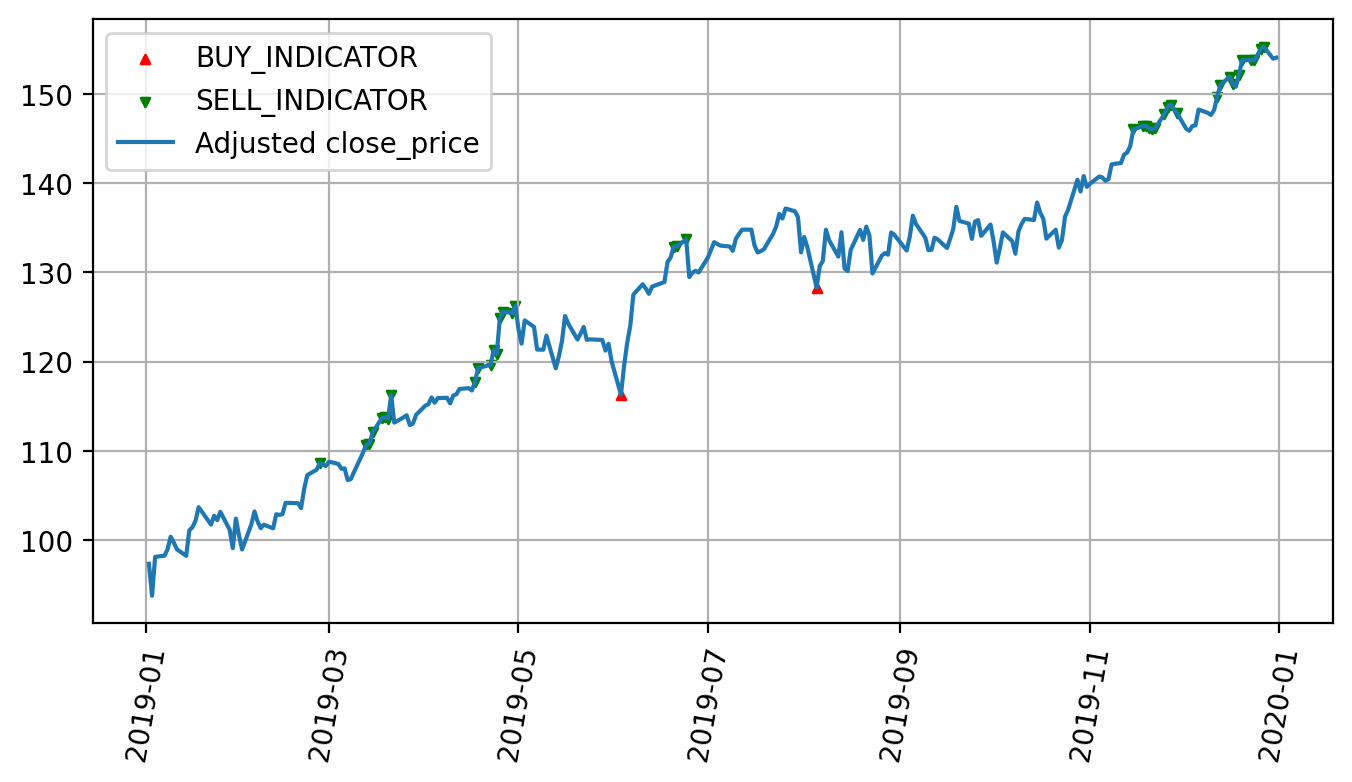

In [51]:




plt.figure(figsize = (8,4), dpi = 200)

# plt.plot(train_RS_msft_df.index, train_RS_msft_df.macd , label = 'MACD')
# plt.plot(train_RS_msft_df.index, train_RS_msft_df.macd_sig , label = 'MACD_SIGNAL')
plt.scatter(train_RSI_msft_df[train_RSI_msft_df.RSI_buy ==1].index, train_RSI_msft_df[train_RSI_msft_df.RSI_buy ==1].Adj_Close , s = 10 ,marker="^",color = 'red', label = 'BUY_INDICATOR')
plt.scatter(train_RSI_msft_df[train_RSI_msft_df.RSI_sell ==1].index, train_RSI_msft_df[train_RSI_msft_df.RSI_sell ==1].Adj_Close ,s = 10, marker="v",color = 'green',label = 'SELL_INDICATOR')
# plt.plot(train_RS_msft_df.index, train_RS_msft_df.bb_bbl , label = 'bb_lower_band')
plt.plot(train_RSI_msft_df.index, train_RSI_msft_df.Adj_Close , label = 'Adjusted close_price')
plt.xticks(rotation=80)
plt.grid()
plt.legend()
plt.show()







In [55]:

def filter_rsi_sigs(df):
    buy_df = df[df.RSI_buy ==1]


    sell_df =  df[df.RSI_sell ==1]

    sig_df  = pd.concat([sell_df, buy_df] , axis =0)
    

    sig_df.sort_index(inplace =True )

    #### Dropping some columns we will not be using

    rsi_df  = sig_df[['Adj_Close', 'RSI_buy', 'RSI_sell']]                            

    return rsi_df





In [56]:
## Filtering the signals
tr_msft_rsi_df = filter_rsi_sigs(train_RSI_msft_df)

In [57]:

criticize(tr_msft_rsi_df,'RSI_buy')

tr_main_trade_df = tr_msft_rsi_df[tr_msft_rsi_df.critic ==1]




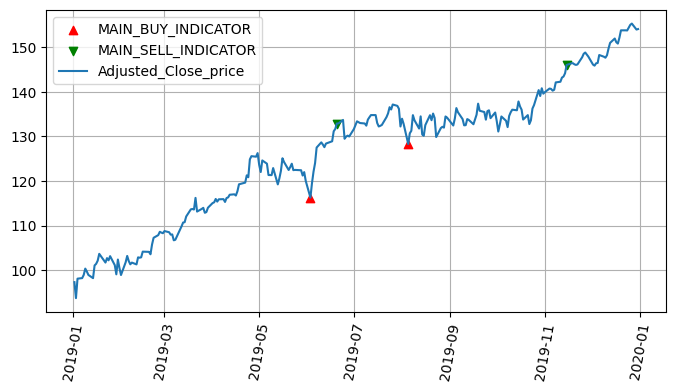

In [58]:

# tst_main_trade_df 
plt.figure(figsize = (8,4), dpi = 100)

plt.scatter(tr_main_trade_df[tr_main_trade_df.RSI_buy ==1].index, tr_main_trade_df[tr_main_trade_df.RSI_buy ==1].Adj_Close  ,marker="^",color = 'red', label = 'MAIN_BUY_INDICATOR')
plt.scatter(tr_main_trade_df[tr_main_trade_df.RSI_sell ==1].index, tr_main_trade_df[tr_main_trade_df.RSI_sell ==1].Adj_Close , marker="v",color = 'green',label = 'MAIN_SELL_INDICATOR')
plt.plot(train_RSI_msft_df.index, train_RSI_msft_df.Adj_Close , label = 'Adjusted_Close_price')
plt.xticks(rotation=80)
plt.grid()
plt.legend()
plt.show()



In [59]:

trsi_backtest_df = backtest(tr_main_trade_df,'RSI_buy', 'RSI_sell' ,10000000,0.01)


trsi_backtest_df




,Buy_Price,Sell_Price,No_of_Stocks,Buy_Date,Buy_commision,Tot_buy_price,Sell_Date,Sell_commision,Tot_sell_price
0,116.298355,132.90271,85125.881542,2019-06-03,100000.0,10000000,2019-06-20,113134.603448,11200325.741311
1,128.302795,146.022552,86423.077911,2019-08-05,112003.257413,11200325.741311,2019-11-15,126197.184306,12493521.246284
